> <p><small><small>This Notebook is made available subject to the licence and terms set out in the <a href = "http://www.github.com/google-deepmind/ai-foundations">AI Research Foundations Github README file</a>.

<img src="https://storage.googleapis.com/dm-educational/assets/ai_foundations/GDM-Labs-banner-image-C3-white-bg.png">

# Lab: Gradients

<a href='https://colab.research.google.com/github/google-deepmind/ai-foundations/blob/master/course_3/gdm_lab_3_7_gradients.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

Automatically compute gradients to incrementally learn decision boundaries.

25 minutes

## Overview

In this lab, you will explore how you can use JAX to compute gradients automatically, a process known as **automatic differentiation** (or **autodiff** for short). You will use the automatically computed gradients to repeatedly make updates to the decision boundary of a binary classifier until it perfectly separates the two classes.





### What you will learn:

By the end of this lab, you will:
* Compute gradients with JAX.
* Investigate how these gradients can be used to update the parameters of a model.

### Tasks

For this activitiy, you will reuse the dataset from the earlier activities where each data point is a two-dimensional prompt embedding. The model's task is to  predict the next token ("food" or "water"). As a model, you will use a single-neuron neural network with a sigmoid activation function.

**In this lab, you will**:
* Load the dataset of 2-dimensional embeddings.
* Manually define the model computations and loss function using functions from JAX.
* Automatically compute the gradients of this model.
* Observe how the decision boundary shifts as you are making updates.

All of these steps are described in detail in the following sections.

## How to use Google Colaboratory (Colab)

Google Colaboratory (also known as Google Colab) is a platform that allows you to run Python code in your browser. The code is written in *cells* that are executed on a remote server.

To run a cell, hover over a cell and click on the `run` button to its left. The run button is the circle with the triangle (▶). Alternatively, you can also click on a cell and use the keyboard combination Ctrl+Return (or ⌘+Return if you are using a Mac).

To try this out, run the following cell. This should print today's day of the week below it.

In [ ]:
from datetime import datetime

print(f"Today is {datetime.today():%A}.")

Note that the order in which you run the cells matters. When you are working through a lab, make sure to always run all cells in order, otherwise the code might not work. If you take a break while working on a lab, Colab may disconnect you and in that case, you have to execute all cells again before  continuing your work. To make this easier, you can select the cell you are currently working on and then choose __Runtime → Run before__  from the menu above (or use the keyboard combination Ctrl/⌘ + F8). This will re-execute all cells before the current one.

## Imports

In this lab, you will primarily use functions from JAX for defining the model, computing the gradient, making parameter updates, and representing the data.

Run the following cell to import all required packages.

In [1]:
%%capture
# Install the custom package for this course.
!pip install "git+https://github.com/google-deepmind/ai-foundations.git@main"

# Packages used.
import jax # For automatically computing gradients.
import jax.numpy as jnp # For defining the model and input matrices.
from IPython.display import display # For displaying the dataset.
import pandas as pd # For loading and displaying the dataset.
from ai_foundations import visualizations # For creating plots.

## Load the dataset

Run the following cell to load and print the dataset. Note, this is the 2-class dataset that you used in one of the early labs in this course, not the 3-class dataset that you have been more recently using to learn about MLPs and hyperparameter tuning.

Also note that for this activity, there is no validation or test set. This is because, the goal of this activity is not to build a model that generalizes best but rather to understand how the training process itself works.

,Prompt,Embedding_dim_1,Embedding_dim_2,Label
0,Jide was hungry so she went looking for,0.27,0.39,food
1,The best part of the street fair was the incre...,1.06,0.89,food
2,He opened the refrigerator and it was full of ...,0.77,0.65,food
3,The main attraction at the festival was the am...,0.66,1.09,food
4,The lion went hunting for,0.61,1.64,food
5,The farmers worked hard to grow a lot of,0.94,1.29,food
6,Her favourite part of visiting new places is t...,0.61,0.78,food
7,The toddlers made a huge mess with their,0.89,1.13,food
8,The market sells a lot of delicious fresh,0.64,0.98,food
9,My doctor advised me to avoid very fatty,0.71,0.41,food


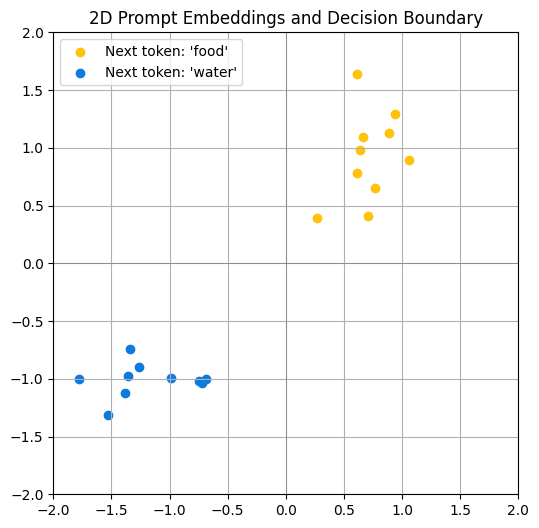

In [2]:
# Load data using pandas.
df = pd.read_csv("https://storage.googleapis.com/dm-educational/assets/ai_foundations/food-water-dataset.csv")

# Extract features (Embedding_dim_1, Embedding_dim_2) and labels.
# Input features (token embeddings).
X_train = jnp.array(df[["Embedding_dim_1", "Embedding_dim_2"]].values)
labels = df["Label"].values # Labels: "food" or "water".

# Convert labels to numeric values for plotting (food = 1, water = 0).
y_train = jnp.where(labels == "food", 1, 0)

# Print and visualize the loaded data for verification.
display(df.head(n=20))

visualizations.plot_data_and_decision_boundary(X_train, labels)

## Coding activity 1: Initial guess

Recall, that the weight vector ($\mathbf{w}$) determines the orientation of the decision boundary, and the bias term ($b$) determines how much the decision boundary is shifted.

<br />

------
> **💻 Your task:**
>
>Change the values of $\mathbf{w}$ and $b$ below
and observe how the decision boundary shifts.
>
>Focus on understanding:
>- How the weight vector ($\mathbf{w}$) defines the slope of the decision boundary.
>- How the bias term ($b$) defines the intercept of the decision boundary.
>- What happens when the weight vector points towards the positive class or the negative class.
>
------


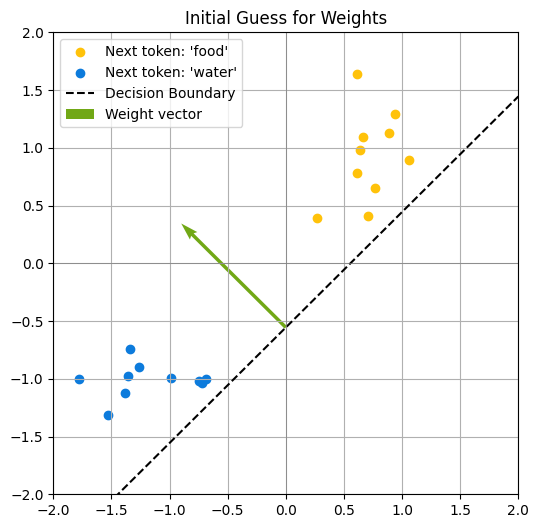

In [3]:
# Change the bias and weights here.
b_initial_guess = jnp.array([0.5])
w_initial_guess = jnp.array([-0.9, 0.9])

# Plot the initial guess for the weight vector.
visualizations.plot_data_and_decision_boundary(
    X_train,
    labels,
    weight_vector=w_initial_guess,
    bias_term=b_initial_guess,
    title="Initial Guess for Weights"
)

## Coding activity 2: Implement the prediction function

In order for JAX to compute the gradients for a model, it needs an implementation of the loss function. The loss function in return needs an implementation of the neural network that outputs predictions.

<br />

------
> **💻 Your task:**
>
> Complete the function `predict` below. This function should implement a single neuron with a sigmoid activation function using tools from `JAX`.
>
> As a reminder, a single neuron makes predictions for an input vector $\mathbf{x}$ as follows:
>
> $$y = \sigma(\mathbf{w} \cdot \mathbf{x} + b)$$
>
> To compute the dot product between two vectors $\mathbf{a}$ and $\mathbf{b}$, you can use the `jnp.dot(a,b)` function. To compute $\sigma(x)$, you can use the `jax.nn.sigmoid(x)` function.
>
> Note, that the input for the predict function is a matrix $X$ rather than a vector. This matrix includes the embedding of one prompt in each row. If you call `jnp.dot` on this matrix instead, it will automatically return a vector $\mathbf{y}$ that contains all predictions for all examples represented by $X$. This alllows you to jointly compute the predictions for all examples in a dataset rather than computing them one-by-one. If you do this, however, you will have to change the order of arguments since you are now performing a matrix multiplication between a matrix $X$ of dimension `number_of_examples x embedding_dim` and a matrix $w$ of dimension `embedding_dim x 1`. Unlike for dot products, the order in which you multiply matrices matters and the second dimension of the first matrix and the first dimension of the second matrix have to be the same. Be sure to consider this when you implement the prediction function below.
------



In [4]:
def predict(w: jax.Array, b: jax.Array, X: jax.Array) -> jax.Array:
    """Computes predicted probabilities using a single neuron.

    This function calculates the dot product of the input features and weights,
    then applies the sigmoid activation function to produce predictions in the
    range [0, 1].

    Args:
        w: The model's weight vector. Expected shape is (embedding_dim,).
        b: The model's bias term. Expected shape is (1,).
        X: The input data matrix where each row is a sample and each column
           is an embedding dimension. Expected shape is
           (number_of_examples, embedding_dim).

    Returns:
        An array of predicted probabilities, one for each sample. The shape
        of the output array is (number_of_examples,).
    """
    z = jnp.dot(X, w) + b
    y = jax.nn.sigmoid(z) # Add your code here.

    return y

## Define the loss function

Run the following cell to define the loss function. As you are training a binary classifier, use the binary cross-entropy loss, where $y_{\mathrm{pred}}$ is the predicted probability for class 1, and $y_{\mathrm{true}}$ is 1 if the true class is 1 ("food"), and 0 ("water") otherwise:

$$\mathrm{Loss}\left(y_{\mathrm{true}}, \, y_{\mathrm{pred}}\right) = -\left[y_{\mathrm{true}} \log \left(y_{\mathrm{pred}}\right) + \left(1-y_{\mathrm{true}}\right) \log \left(1-y_{\mathrm{pred}}\right)\right]$$

A common way to compute the loss across an entire dataset is to compute the average loss across all examples. This is done with the `jnp.mean` function below.

The loss function below uses the current weights $\mathbf{w}$ and the current bias term $b$ to compute the model predictions on the entire dataset using the `predict` function that you implemented above. This has the advantage of making the loss function directly depend on $\mathbf{w}$ and $b$ and the automatic differentiation tools can then automatically compute the gradients for the loss function with respect to $\mathbf{w}$ and $b$.

In [5]:
def loss_fn(
    w: jax.Array, b: jax.Array, X: jax.Array, y_true: jax.Array
) -> jax.Array:
    """Computes the binary cross-entropy loss.

    This loss function is suitable for binary classification tasks. It
    quantifies the difference between the true binary labels and the
    probabilities predicted by the model. A small epsilon value is added for
    numerical stability to avoid log(0).

    Args:
      w: The model's weight vector. Expected shape is (embedding_dim,).
      b: The model's bias term. Expected shape is (1,).
      X: The input data matrix.
        Expected shape is (number_of_examples, embedding_dim).
      y_true: The true binary labels (0 or 1).
        Expected shape is (number_of_examples,).

    Returns:
      The mean binary cross-entropy loss as a scalar value.
    """
    y_pred = predict(w, b, X)
    # Add a small epsilon for numerical stability.
    epsilon = 1e-8
    return jnp.mean(
        -(
            y_true * jnp.log(y_pred + epsilon)
            + (1 - y_true) * jnp.log(1 - y_pred + epsilon)
        )
    )

Run the following cell to compute the loss for a classifier using your manually set weights on the training dataset.

In [6]:
# Compute the loss for the initial weights.
print(
    "Loss for current weights:"
    f" {loss_fn(w_initial_guess, b_initial_guess, X_train, y_train):.4f}"
)

Loss for current weights: 0.7512


## Compute the gradients and update the weights

You will now perform one automatic training step. The cell below uses JAX's `grad` function to define a function that can automatically compute the gradient of the loss function on a dataset.

This gradient tells you how to adjust the weights and the bias terms to reduce the loss.

For the update, you will compute the updated weight vector as

```python
w_updated = w_current - learning_rate * gradient_w  
```

and the updated bias term as:

```python
b_updated = b_current - learning_rate * gradient_b  
```

That means you subtract the gradient from the original weight vector. In order to make small, incremental updates, the gradient is multiplied with the `learning_rate` hyperparameter. This is set to a value smaller than 1.0, in fact, usually much smaller than 1.0.
(The reason for making incremental updates will be explained in later activities.)

Run the following cell to perform one automatic updating step.

Focus on understanding:
- How the gradient points in the direction of the **steepest ascent** (you subtract the gradient to go in the direction of the steepest descent).
- How applying the gradient moves the weights towards better classifying the data.

Gradients: gradient_w = [-0.52078897 -0.47502044], gradient_b = [0.15776236]
Loss before update: 0.7512
Loss after update: 0.7002


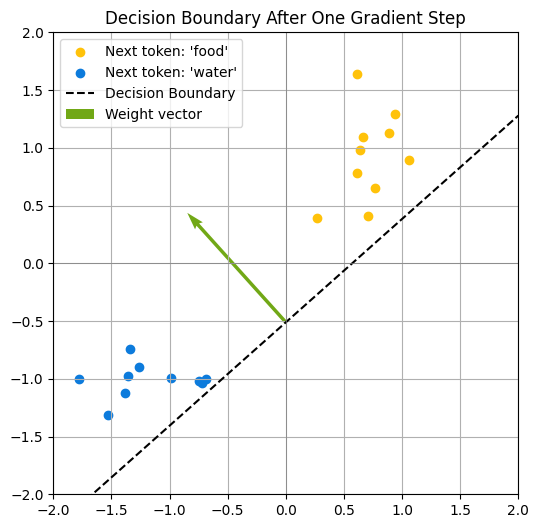

In [7]:
# Reset the initial guess.
b_initial_guess = jnp.array([0.5])
w_initial_guess = jnp.array([-0.9, 0.9])

# Define the gradient function that computes the gradient of the loss function.
# `argnums=[0,1]` tells the automatic differentation method that it should
# compute the gradient with respect to the first and the second argument of the
# loss function, which are the weights and the bias term.
grad = jax.grad(loss_fn, argnums=[0, 1])

# Apply one gradient step.

# Step size for updating the weights.
learning_rate = 0.1

# Compute the gradient.
gradient = grad(w_initial_guess, b_initial_guess, X_train, y_train)
print(f"Gradients: gradient_w = {gradient[0]}, gradient_b = {gradient[1]}")
print(
    f"Loss before update:"
    f" {loss_fn(w_initial_guess, b_initial_guess, X_train, y_train):.4f}"
)

# `gradient` is a tuple that contains the gradient with respect to the weight
# vector and the gradient with respect to the bias term.
gradient_w, gradient_b = gradient

# Update the weights and bias term.
w_updated = w_initial_guess - learning_rate * gradient_w
b_updated = b_initial_guess - learning_rate * gradient_b

print(
    f"Loss after update:"
    f" {loss_fn(w_updated, b_updated, X_train, y_train):.4f}"
)

# Plot the initial guess for the weight vector.
visualizations.plot_data_and_decision_boundary(
    X_train,
    labels,
    weight_vector=w_updated,
    bias_term=b_updated,
    title="Decision Boundary After One Gradient Step",
)

### Gradient descent

The gradient descent algorithm works by repeatedly performing updates to the weight vector and the bias term using the gradient update formulas from above:

```python
w = w - learning_rate * gradient_w  
```

and

```python
b = b - learning_rate * gradient_b  
```

Here, `w` and `b` store the current value of the weights and the bias term, which need to be initialized at the beginning of the training process. In practice, this intialization is usually done randomly but here, it is initialized with the values in `w_initial_guess` and `b_initial_guess`.

These updates are performed as part of the training loop. Each iteration of this training loop corresponds to one epoch, so the number of times this loop gets executed is the number of epochs. With each iteration, the training loss decreases and the model becomes better at making predictions on examples in the training data.

Run the following cell to repeatedly apply the gradient updates to see how the weights evolve over time.

Focus on observing:
- How the decision boundary shifts closer to separating the two classes.
- How the weight vector gradually aligns with the positive class.

Step 1 loss: 0.5195


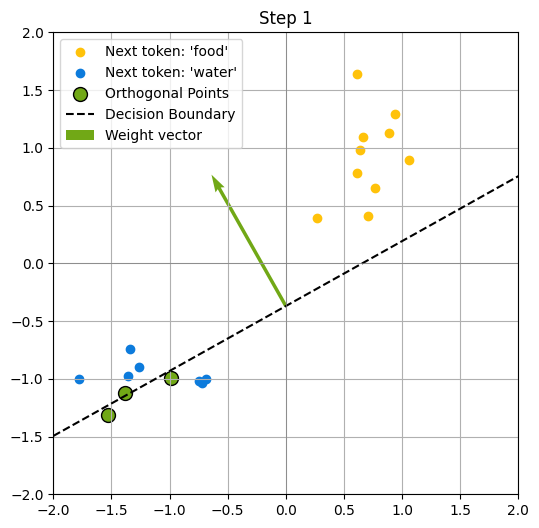

Step 2 loss: 0.3809


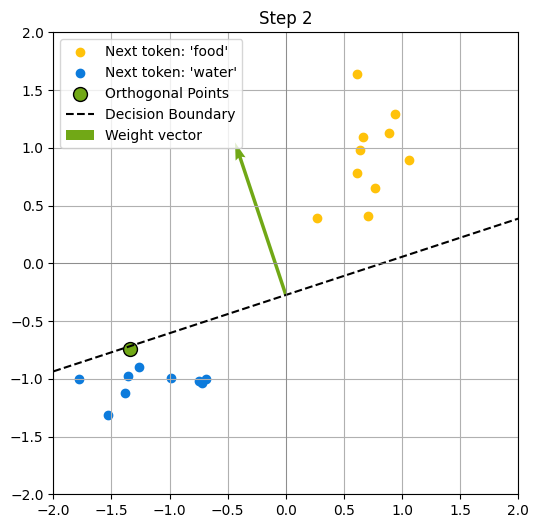

Step 3 loss: 0.2967


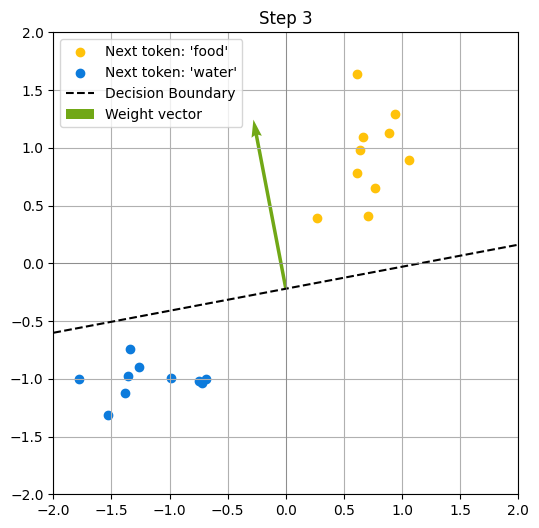

Step 4 loss: 0.2426


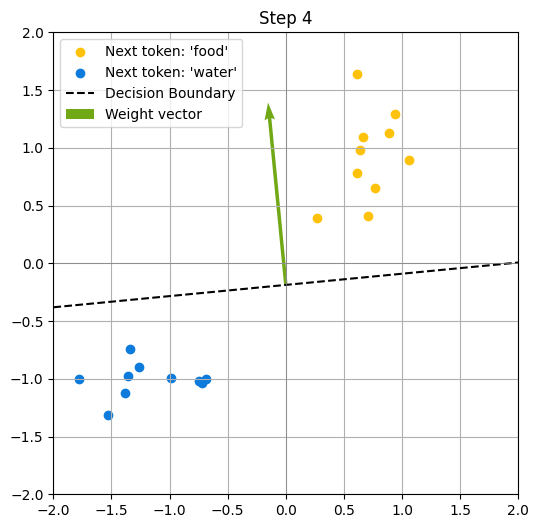

Step 5 loss: 0.2054


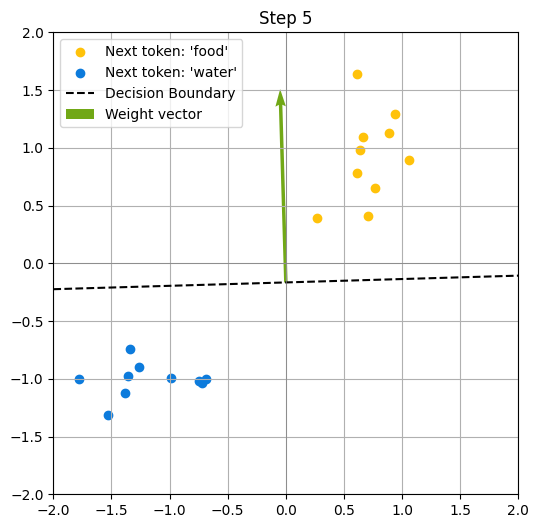

Step 6 loss: 0.1785


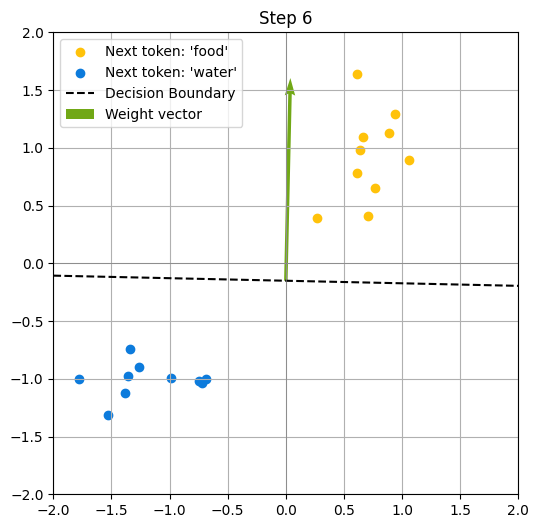

Step 7 loss: 0.1582


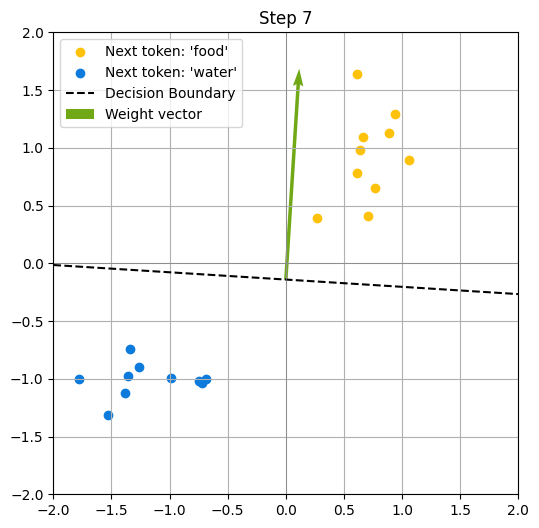

Step 8 loss: 0.1422


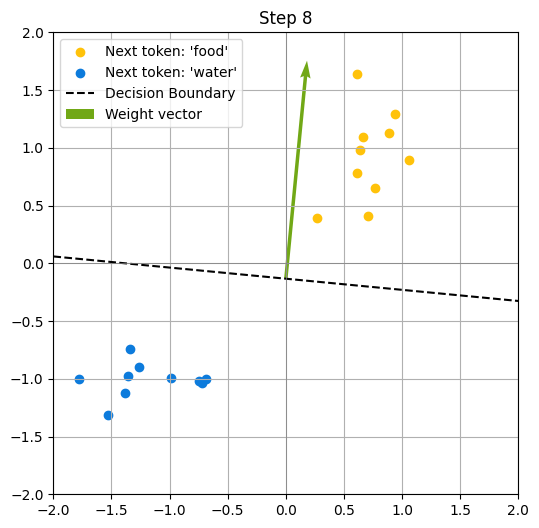

Step 9 loss: 0.1294


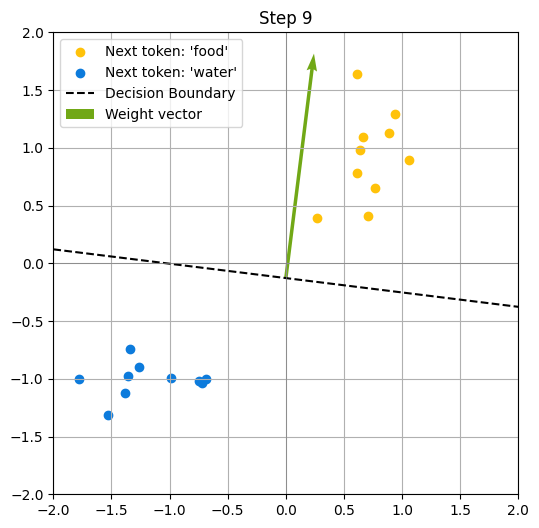

Step 10 loss: 0.1189


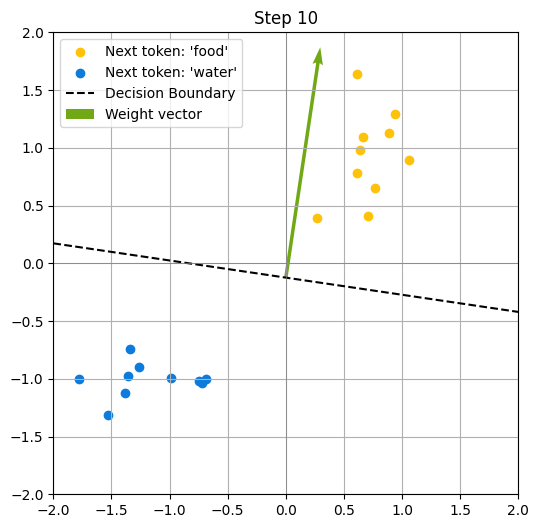

In [8]:
# Intialize the weight vector.
w = w_initial_guess
b = b_initial_guess
learning_rate = 0.5

for step in range(10):  # Perform 10 update steps.

    # Compute the gradients.
    gradient = grad(w, b, X_train, y_train)
    gradient_w, gradient_b = gradient

    # Update the weights and bias term.
    w = w - learning_rate * gradient_w
    b = b - learning_rate * gradient_b

    print(f"Step {step + 1} loss: {loss_fn(w, b, X_train, y_train):.4f}")

    visualizations.plot_data_and_decision_boundary(
        X_train,
        labels,
        weight_vector=w,
        bias_term=b,
        title=f"Step {step + 1}"
    )

You have now seen what happens during model training. While this process is much more complex for models with multiple layers with many neurons, the principles are exactly the same. On each iteration, the gradient of the loss function is computed and this gradient is used to update the parameters. If this step is repeated many times for all examples in the training data, the model can learn sophisticated patterns.

## More complex machine learning problems

------
> **💭 Reflection:**
>
> Run the following cell to plot the spiral dataset that contains datapoints separated into four classes. Then reflect upon the models and methods you have learned in this and previous activities.
>
>* How would you extend the logistic regression model to support more than two classes (e.g., four in this case)?
>
>* Could a classifier with a single activation function such as a logistic regression model properly separate this data? Why or why not?
>
-----



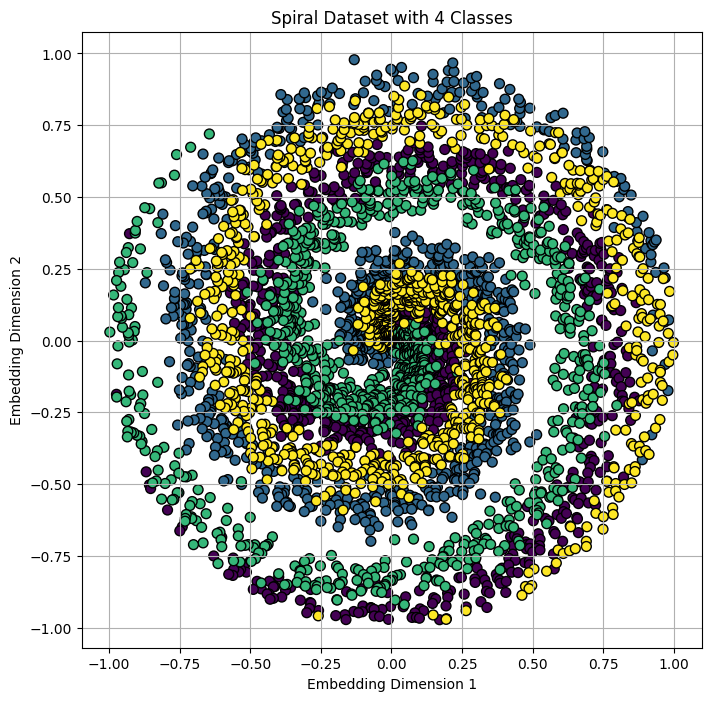

In [9]:
visualizations.plot_spiral_data(
    "https://storage.googleapis.com/dm-educational/assets/ai_foundations/spiral-dataset.csv"
)

## Summary
In this activitiy, you learned how you can automatically compute **gradients** using the `JAX` package. You then used these gradients to run **gradient descent** and learn model parameters that created a good decision boundary for the dataset. This demonstrated the training process of any neural network model, regardless of its complexity.

In the following activities, you will learn more about how the gradient updates and how the updates are performed when you are training the model on a much bigger dataset.



## Solutions

The following cells provide reference solutions to the coding activities in this notebook. If you really get stuck after trying to solve the activities yourself, you may want to consult these solutions.

It is recommended that you *only* look at the solutions after you have tried to solve the activities *multiple times*. The best way to learn challenging concepts in computer science and artificial intelligence is to debug your code piece-by-piece until it works, rather than copying existing solutions.

If you feel stuck, you may want to first try to debug your code. For example, by adding additional print statements to see what your code is doing at every step. This will provide you with a much deeper understanding of the code and the materials. It will also provide you with practice on how to solve challenging coding problems beyond this course.

To view the solutions for an activity, click on the arrow to the left of the activity name. If you consult the solutions, do not copy and paste them into the cells above. Instead, look at them, and type them manually into the cell. This will help you understand where you went wrong.


### Coding Activity 1

In [ ]:
# One potential solution.
b_initial_guess = jnp.array([0.0])
w_initial_guess = jnp.array([1.0, 1.0])

### Coding Activity 2

In [ ]:
def predict(w: jax.Array, b: jax.Array, X: jax.Array) -> jax.Array:
    """Computes predicted probabilities using a single neuron.

    This function calculates the dot product of the input features and weights,
    then applies the sigmoid activation function to produce predictions in the
    range [0, 1].

    Args:
        w: The model's weight vector. Expected shape is (embedding_dim,).
        b: The model's bias term. Expected shape is (1,).
        X: The input data matrix where each row is a sample and each column
           is a feature. Expected shape is (number_of_examples, embedding_dim).

    Returns:
        An array of predicted probabilities, one for each sample. The shape
        of the output array is (number_of_examples,).
    """

    y = jax.nn.sigmoid(jnp.dot(X, w) + b)

    return y